In [ ]:
import pandas as pd
!pip install transformers

     |████████████████████████████████| 4.2 MB 4.8 MB/s 
     |████████████████████████████████| 6.6 MB 46.2 MB/s 
     |████████████████████████████████| 84 kB 3.2 MB/s 
     |████████████████████████████████| 596 kB 42.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1C5qzk9PJBlzPMlTG36g0I0d4HLPivf6L/view?usp=sharing' 

In [ ]:
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Train_Dec.csv') 
 
df = pd.read_csv('Train_Dec.csv')
df

,text
0,@Alyssafarah They started the armed conflict a...
1,Tucker Carlson emphasized on how much Ukraine ...
2,"Since day one, the military fighting against U..."
3,A notable Russian OSS developer promotes a pro...
4,US believes Russia could invade Ukraine ‘as so...
...,...
56126,@20committee Russia could roll through Ukraine...
56127,Russia Preparing 175K Troops For Ukraine Offen...
56128,"@politicalblond In other words, Russia is Male..."
56129,How the US Military Could Mobilize If Russia I...


In [ ]:
df['Sentiment'] = 0

In [ ]:
df

,text,Sentiment
0,@Alyssafarah They started the armed conflict a...,0
1,Tucker Carlson emphasized on how much Ukraine ...,0
2,"Since day one, the military fighting against U...",0
3,A notable Russian OSS developer promotes a pro...,0
4,US believes Russia could invade Ukraine ‘as so...,0
...,...,...
56126,@20committee Russia could roll through Ukraine...,0
56127,Russia Preparing 175K Troops For Ukraine Offen...,0
56128,"@politicalblond In other words, Russia is Male...",0
56129,How the US Military Could Mobilize If Russia I...,0


In [ ]:
from google.colab import drive
drive.mount('drive')
import sys
sys.path.append('drive/My Drive/Colab Notebooks')

Mounted at drive


In [ ]:
#code from NLPiation

import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

# The dataset class
class TheDataset(torch.utils.data.Dataset):

    def __init__(self, reviews, sentiments, tokenizer):
        self.reviews    = reviews
        self.sentiments = sentiments
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, index):
        review = str(self.reviews[index])
        sentiments = self.sentiments[index]

        encoded_review = self.tokenizer.encode_plus(
            review,
            add_special_tokens    = True,
            max_length            = 128,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors        = 'pt',
            padding               = "max_length",
            truncation            = True
        )

        return {
            'input_ids': encoded_review['input_ids'][0],
            'attention_mask': encoded_review['attention_mask'][0],
            'labels': torch.tensor(sentiments, dtype=torch.long)
        }

# Prepare the Train/Validation sets
#train_set_dataset = TheDataset(
    #reviews    = train_set.text.tolist(),
    #sentiments = train_set.Sentiment.tolist(),
    #tokenizer  = tokenizer,
#)

#valid_set_dataset = TheDataset(
    #reviews    = valid_set.text.tolist(),
    #sentiments = valid_set.Sentiment.tolist(),
    #tokenizer  = tokenizer,
#)

# Load the BERT model
#model = BertForSequenceClassification.from_pretrained("drive/My Drive/Colab Notebooks/epoch 4", problem_type="single_label_classification", num_labels=3)

# Freeze the whole BERT model and train just the classifier
#for name, param in model.bert.named_parameters():
    #param.requires_grad = False

# Freeze BERT except the pooler layer
#for name, param in model.bert.named_parameters():
    #if not name.startswith('pooler'):
        #param.requires_grad = False

# Freeze the first 18 layers of the BERT
#for name, param in model.bert.named_parameters():
    #if ( not name.startswith('pooler') ) and "layer.23" and "layer.22" and "layer.21" and "layer.20" and "layer.19" and "layer.18" not in name :
        #param.requires_grad = False

# The function to get the accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the training parameters
training_args = TrainingArguments(
    output_dir                  = 'drive/My Drive/Colab Notebooks',
    num_train_epochs            = 2,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 64,
    warmup_steps                = 10000,
    learning_rate               = 5e-5,
    weight_decay                = 0.01,
    adam_beta1                  = 0.9,
    adam_beta2                  = 0.999,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    eval_steps                  = 1,
    #save_total_limit            = 5,
    #metric_for_best_model       = 'eval_loss',
    load_best_model_at_end      =True
)

# Define the Huggingface Trainer object
#trainer = Trainer(
    #model           = model,
    #args            = training_args,
    #train_dataset   = train_set_dataset,
    #eval_dataset    = valid_set_dataset,
    #compute_metrics = compute_metrics,
    #callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
#)

#trainer.train()

In [ ]:
# Load the checkpoint
model = BertForSequenceClassification.from_pretrained("drive/My Drive/Colab Notebooks/checkpoint-11228", num_labels=3)

# Make the test set ready
test_set_dataset = TheDataset(
    reviews    = df.text.tolist(),
    sentiments = df.Sentiment.tolist(),
    tokenizer  = tokenizer,
)

training_args = TrainingArguments(
    output_dir = 'drive/My Drive/Colab Notebooks',
    do_predict = True
)

trainer = Trainer(
    model           = model,
    args            = training_args,
    compute_metrics =compute_metrics,
)

PredictionOutput = trainer.predict(test_set_dataset)

In [ ]:
PredictionOutput

In [ ]:
PredictionOutput[0][4]

In [ ]:
df['Bert_Large label'] = [np.argmax(i) for i in (PredictionOutput[0])]

In [ ]:
df['Bert_Large label'].replace({0: "negative", 1: "neutral", 2: 'positive'}, inplace=True)

In [ ]:
results = df['Bert_Large label'].value_counts()

In [ ]:
results

In [ ]:
from google.colab import drive
drive.mount('drive')

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

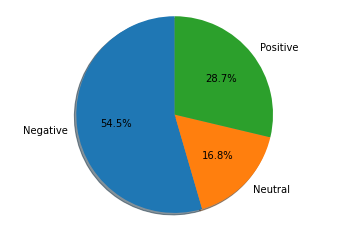

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Negative', 'Neutral', 'Positive'
sizes = [30596, 9420, 16115]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('BERT_Large_Dec_Results.png')
files.download('BERT_Large_Dec_Results.png')
plt.show()